# French road names analysis

## Using FANTOIR

### Import data

Data is from the FANTOIR public dataset, updated every trimester by the French tax administration (DGFIP). The data I use below is the 07/2020 version, preprocessed to csv format by the Geonov project - see link: https://www.geonov.fr/smartdata/fantoir/.

In [1]:
import pandas as pd

In [2]:
roads = pd.read_csv('/Users/Thomas/Downloads/FANTOIR_COMPLET/740_HAUTE_SAVOIE/CSV/740_HAUTE_SAVOIE_VOIE.csv', sep=';')
roads

,ccodep,ccodir,ccocom,ccoriv,clerivili,natvoi,libvoi,typcom,ruract,carvoi,poprel,poppart,popfict,annul,dteannul,dtecreart,codvoi,typvoi,indldnbat,motclas
0,74,0,1,B001,M,NaN,ABONDANCE,N,3,0,NaN,0,0,NaN,0,1990088,1,3,0.0,ABONDANC
1,74,0,1,B002,N,NaN,ADROIT DE LA COMBE,N,3,0,NaN,0,0,NaN,0,1991195,2,3,1.0,COMBE
2,74,0,1,B003,P,NaN,ARCES,N,3,0,NaN,0,0,NaN,0,1990088,3,3,0.0,ARCES
3,74,0,1,B004,R,NaN,ARDENS,N,3,0,NaN,0,0,NaN,0,1990088,4,3,0.0,ARDENS
4,74,0,1,B005,S,NaN,AUTIGNY,N,3,0,NaN,0,0,NaN,0,1990088,5,3,0.0,AUTIGNY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70059,74,0,315,0310,B,CHE,DE LA RUAZ,N,3,0,NaN,0,0,NaN,0,2001115,158,1,NaN,RUAZ
70060,74,0,315,0360,F,RUE,DES TERROZ,N,3,0,NaN,0,0,NaN,0,2007204,167,1,NaN,TERROZ
70061,74,0,315,0380,C,PL,DU THAY,N,3,0,NaN,0,0,NaN,0,1990332,137,1,NaN,THAY
70062,74,0,315,0385,H,CHEM,DES VAUDOIS,N,3,0,NaN,0,0,NaN,0,2007204,168,1,NaN,VAUDOIS


In [3]:
# from: https://www.geonov.fr/smartdata/fantoir/
#abbreviations = pd.read_clipboard()
#abbreviations

In [4]:
abbreviations = pd.read_html('https://www.geonov.fr/smartdata/fantoir/#post-content%20>%20table:nth-child(23)')[2]
abbreviations

,Attribut,Description
0,ccodep,Code département
1,ccodir,Code direction
2,ccocom,Code commune
3,ccoriv,Identifiant de la voie dans la commune
4,clerivili,Clé RIVOLI
5,natvoi,Code nature de voie
6,libvoi,Libellé voie
7,typcom,Type de la commune
8,ruract,Caractère RUR
9,carvoi,Caractère de voie


In [5]:
roads = roads[['natvoi', 'libvoi', 'motclas']]
roads

,natvoi,libvoi,motclas
0,NaN,ABONDANCE,ABONDANC
1,NaN,ADROIT DE LA COMBE,COMBE
2,NaN,ARCES,ARCES
3,NaN,ARDENS,ARDENS
4,NaN,AUTIGNY,AUTIGNY
...,...,...,...
70059,CHE,DE LA RUAZ,RUAZ
70060,RUE,DES TERROZ,TERROZ
70061,PL,DU THAY,THAY
70062,CHEM,DES VAUDOIS,VAUDOIS


### A few statistics

In [6]:
roads.describe()

,natvoi,libvoi,motclas
count,24402,70064,70063
unique,78,43864,18758
top,CHE,LES COMBES,BOIS
freq,6898,109,463


In [7]:
from pandas_profiling import ProfileReport

profile = ProfileReport(roads)
profile.to_notebook_iframe()

/Users/Thomas/opt/miniconda3/envs/ox/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [8]:
import qgrid

interactive = qgrid.show_grid(roads, show_toolbar = True)
interactive

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Using OSMNx

In [8]:
import pandas as pd
from unidecode import unidecode
import osmnx as ox
ox.config(use_cache=True, log_console=True)
from osmnx import utils_graph
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import wikipedia
wikipedia.set_lang('fr')
from itertools import chain
import json
import folium

### Define road gender classifier

I want to classify the roads with famous people's names as either masculine or feminine, and the others as neutral. The steps I will go through are:
1. use a list of all French first names + associated gender in order to classify the roads that include a first name. I used the list of all first names between 1900 and 2019 published by INSEE at this address: https://www.insee.fr/fr/statistiques/2540004?sommaire=4767262#consulter. Another option was the `Genderize` package, which gives the gender of an English first name - but it's not so good for French first names.
<br>
<br>
2. Do the same with English first names, extracted from the list of all first names given in Scotland since 1910 - available at https://www.nrscotland.gov.uk/files//statistics/babies-names/19/babies-first-names-all-names-all-years.csv.
<br>
<br>
3. to classify some of the roads without a first name, hard-code the gender of a list of words commonly included in street names - mainly titles such as 'Maréchal', 'Général', 'Professeur', 'Président', 'Père', 'Madame', 'Monsieur', etc.
<br>
<br>
4. to classify the remaining roads named after a famous person but not including its first name (ex: 'Rue Monge'), use the `wikipedia` package to search for the 2nd word (ex: 'Monge') on Wikipedia. If one of the 3 first results includes a first name, it's highly likely that the road name corresponds to a person, and we can classify their gender.

* French first names

In [9]:
# download and clean INSEE's list of first names
genders = pd.read_csv('https://www.insee.fr/fr/statistiques/fichier/2540004/nat2019_csv.zip', sep=";")[['preusuel','sexe', 'nombre']]
genders['preusuel'] = genders['preusuel'].apply(str)
genders['preusuel'] = genders['preusuel'].apply(str.lower)
genders['preusuel'] = genders['preusuel'].apply(unidecode)
genders = genders.sort_values('nombre').drop_duplicates('preusuel', keep='last')
genders = genders[genders['nombre']>=100]

In [10]:
# remove first names that create classification mistakes
mistakes = ['france', 'alma', 'barbe', 'lilas', 'milan', 'brune', 'felicite',
            'nancy', 'grace', 'lorraine', 'blanche', 'evy', 'loup', 'iris']
genders = genders[~genders['preusuel'].isin(mistakes)]

genders = genders.reset_index(drop=True).drop(columns=['nombre'])
genders

,preusuel,sexe
0,elyssa,2
1,ben,1
2,nessim,1
3,natalia,2
4,onur,1
...,...,...
2213,_prenoms_rares,2
2214,nathalie,2
2215,michel,1
2216,marie,2


In [11]:
# test
genders[genders['preusuel']=='manuel']
#wikipedia.search('marconi')

,preusuel,sexe
1737,manuel,1


* English first names

In [12]:
# download and clean NRS Scotland's list of first names
genders_en = pd.read_csv('https://www.nrscotland.gov.uk/files//statistics/babies-names/19/babies-first-names-all-names-all-years.csv')[['sex','FirstForename','number']]
genders_en = genders_en[genders_en['number']>=20]
genders_en['preusuel'] = genders_en['FirstForename'].apply(lambda x: unidecode(str.lower(str(x))))
genders_en = genders_en.drop_duplicates('preusuel')
genders_en = genders_en[~genders_en['preusuel'].isin(mistakes)]
genders_en['sexe'] = genders_en['sex'].apply(lambda x: 1 if x=='B' else 2)
genders_en = genders_en.reset_index(drop=True).drop(columns=['FirstForename','number','sex'])
genders_en

,preusuel,sexe
0,david,1
1,john,1
2,paul,1
3,mark,1
4,james,1
...,...,...
1011,river,2
1012,addison,2
1013,cleo,2
1014,mylah,2


In [13]:
# test
genders_en[genders_en['preusuel']=='timothy']

,preusuel,sexe
103,timothy,1


* Common gendered street names

In [14]:
more_names = {# titles
              'Maréchal':1, 'Maréchaux':1, 'Général':1, 'Capitaine':1, 'Commandant':1, 'Adjudant':1,
              'Colonel':1, 'Amiral':1, 'Amiraux':1, 'Caporal':1, 'Sergent':1, 'Brigadier':1,
              'Soldat':1, 'Lieutenant':1, 'Major':1, 'Commandeur':1,
              
              'Saint':1, 'Saints':1, 'Sainte':2, 'Saintes':2, 'Révérend':1, 'Mère':2, 'Père':1,
              'Bienheureux':1, 'Bienheureuse':2, 'Bienheureuses':2, 'Chanoine':1, 'Cardinal':1,
              'Evêque':1, 'Evêques':1, 'Archevêque':1, 'Abbé':1, 'Abbesse':2, 'Vicaire':1, 'Papes':1,
              'Dieu':1, 'Dieux':1, 'Déesse':2, 'Déesses':2, 'Capucins':1, 'Capucines':2, 'Moine':1,
              'Moines':1, 'Moniales':2,
              
              'Duc':1, 'Ducs':1, 'Duchesse':2, 'Duchesses':2, 'Comte':1, 'Comtes':1, 'Comtesse':2, 
              'Comtesses':2, 'Vicomte':1, 'Vicomtesse':2, 'Baron':1, 'Barons':1, 'Baronne':2,
              'Baronnes':2, 'Princesse':2, 'Prince':2, 'Roi':1, 'Rois':1, 'Reine':2, 'Reines':2,
              'Marquise':2, 'Marquis':1, 'Lord':1, 'Lady':2, 'Dauphin':1, 'Dauphine':2, 'Chevalier':1, 
              'Archiduc':1, 'Infante':2, 'Empereur':1, 'Emperesse':2, 'Régent':1, 'Régente':2,
              'Chatelain':1, 'Chatelaine':2, 'Chapelaines':2,
              
              'Président':1, 'Présidente':2, 'Consul':1, 'Maire':1, 'Ambassadeur':1, 'Ambassadeurs':1,
              'Ambassadrice':2, 'Ambassadrices':2, 'Directeur':1, 'Directrice':2, 'Docteur':1, 'Inspecteur':1,
              
              'Professeur':1, 'Maître':1, 'Maîtresse':2, 'Joueur':1, 'Joueurs':1, 'Joueuse':2, 'Joueuses':2,
              'Fille':2, 'Filles':2, 'Fils':1, 'Soeur':2, 'Soeurs':2, 'Frère':1, 'Frères':1,
                          
              'Mademoiselle':2, 'Demoiselle':2, 'Demoiselles':2, 'Dame':2, 'Dames':2, 'Messieurs':1, 'Mesdames':2,
              'Monseigneur':1, 'Seigneur':1, 'Seigneurs':1, 'Messire':1, 'Madame':2, 'Monsieur':1,
              
              # mistakes
              'Vinci':1, 'Gogh':1, 'Rembrandt':1, 'Gandhi':1, 'Sisley':1, 'Loo':1, 'Péguy':1, 'Turgot':1,
              'Pleyel':1, 'Jenner':1, 'Chanez':1, 'Auber':1, 'Pradier':1, 'Huysmans':1, 'Barrault':1,
              'Richer':1, 'Boutin':1, 'Fortuny':1, 'Bouchardon':1, 'Valadon':1, 'Payenne':1, 'Brey':1,
              'Godefroy':1, 'Tagore':1, 'Berthollet':1, 'Nobel':1, 'Viollet':1, 'Vavin':1, 'Rossini':1,
              'Castille':2, 'Brun':1, 'Boétie':1, 'Evariste':1, 'Godefroy':1, 'Valois':1, 'Goncourt':1,
              'Tchaikovsky':1, 'Nicolai':1, 'Paganini':1, 'Bernoulli':1, 'Alembert':1, 'Marx':1, 'Franklin':1,
              'Reynaldo':1, 'Berri':1, 'Bruyere':1, 'Lesseps':1, 'Fenelon':1, 'Mareuil':1,
              'Dupont':1, 'Malmaisons':2, 'Malmaison':2, 'Valois':1, 'Blaise':1, 'Bougainville':1, 'Louvois':1,
              'Colbert':1, 'Faustin':1, 'Chavez':1, 'Mozart':1, 'Desprez':1, 'Froidevaux':1, 'Chapon':1,
              'Gluck':1, 'Berthier':1, 'Grimaud':1, 'Chapon':1, 'Bouvier':1, 'Gauthey':1, 'Dyck':1, 'Monceau':0,
              'Royal':0, 'Favart':1, 'Rauch':1, 'Jonquoy':1, 'Gerando':1, 'Bruller':1, 'Cepre':1, 'Pinel':1,
              'Laferrière':1, 'Gaetano':1, 'Lentonnet':1, 'Mignot':1, 'Mayet':1, 'Pasquier':1, 'Taylor':1,
              'Dubois':1, 'Brunel':1, 'Hebert':1, 'Lagrange':1, 'Junot':1, 'Dieulafoy':1, 'Houdart':1,
              'Franz':1, 'Mouraud':1, 'Andrieux':1, 'Valette':1, 'Joubert':1, 'Ferrus':1, 'Portefoin':1,
              'Hoche':1, 'Fourneyron':1, 'Lemercier':1, 'Polonceau':1, 'Sibour':1, 'Petrarque':1, 'Bourgoin':1,
              'Thouin':1, 'Benard':1, 'Guénégaud':1, 'Tracy':1, 'Calmels':1, 'Geoffroi':1, 'Villiot':1,
              'Greffulhe':1, 'Tarbé':1, 'Daunay':1, 'Larribe':1, 'Riboutté':1, 'Johannes':1, 'Iannis':1,
              'Guglielmo':1, 'Guillermo':1}

more_names = pd.DataFrame.from_dict(more_names, orient='index')
more_names = more_names.reset_index()
more_names.columns = ['preusuel','sexe']
more_names

,preusuel,sexe
0,Maréchal,1
1,Maréchaux,1
2,Général,1
3,Capitaine,1
4,Commandant,1
...,...,...
234,Riboutté,1
235,Johannes,1
236,Iannis,1
237,Guglielmo,1


In [15]:
genders = pd.concat([genders, more_names, genders_en], axis=0)
genders = genders.drop_duplicates('preusuel')
genders =  genders.reset_index(drop=True)
genders['preusuel'] = genders['preusuel'].apply(lambda x: unidecode(str.lower(str(x))))
genders

,preusuel,sexe
0,elyssa,2
1,ben,1
2,nessim,1
3,natalia,2
4,onur,1
...,...,...
3050,erik,1
3051,olive,2
3052,river,2
3053,addison,2


* Define classification function

In [16]:
def classify_gender(name: list):
    
    # set gender to neutral
    g = 0
    
    # iterate through elements of the road name to try classifying
    for el in name:
        try:
            g = int(genders[genders['preusuel']==el]['sexe'])
            break
        except:
            continue
    
    # for the names that remained neutral, search wikipedia
    if g == 0 and len(name)==2:
        results = wikipedia.search(name[1])[:4]
        results = [re.split(" |\-|\'", k) for k in results]
        results = list(chain.from_iterable(results))
        for k in results:
            k = unidecode(str.lower(str(k)))
            try:
                g = int(genders[genders['preusuel']==k]['sexe'])
                break
            except:
                continue  
                
    elif g == 0 and len(name)==3 and name[1] in ['le','la', 'de']:
        results = wikipedia.search(name[2])[:3]
        results = [re.split(" |\-|\'", k) for k in results]
        results = list(chain.from_iterable(results))
        for k in results:
            k = unidecode(str.lower(str(k)))
            try:
                g = int(genders[genders['preusuel']==k]['sexe'])
                break
            except:
                continue  
    
    return g

In [17]:
# testing
#n = ['rue', 'notre', 'dame']
n = ['avenue', 'ingres']
classify_gender(n)

1

### Example: apply to my neighborhood

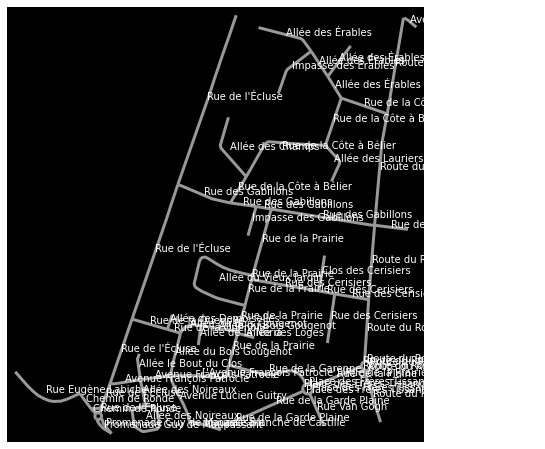

In [17]:
# Get road graph and road names from OSMNx

G = ox.graph_from_address('Croissy-sur-Seine', dist=400, network_type='drive')
G = ox.get_undirected(G)

fig, ax = ox.plot_graph(G, bgcolor='k', edge_linewidth=3, node_size=0,
                        show=False, close=False)
for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():
    c = edge['geometry'].centroid
    text = edge['name']
    ax.annotate(text, (c.x, c.y), c='w')
plt.show()

In [18]:
# clean list of road names
roads = ox.graph_to_gdfs(G, nodes=False)[['name']]
roads_list = [x for x in roads['name'] if type(x) == str]
roads_list = list(dict.fromkeys(roads_list))
roads_list

['Avenue de Saint-Germain',
 'Promenade Guy de Maupassant',
 "Rue de l'Écluse",
 'Rue des Gabillons',
 'Rue de la Prairie',
 'Route du Roi',
 'Rue de la Côte à Bélier',
 'Rue des Cerisiers',
 'Allée des Érables',
 'Allée des Lauriers',
 'Impasse des Érables',
 'Allée des Champs',
 'Rue de la Garenne',
 'Avenue François Patrocle',
 'Avenue Lucien Guitry',
 'Allée du Bois Gougenot',
 'Allée des Noireaux',
 'Allée le Bout du Clos',
 'Impasse Blanche de Castille',
 'Rue de la Quenolle',
 'Allée de la Noria',
 'Allée des Loges',
 'Allée du Vieux Jardin',
 'Place des Frères Tissandier',
 'Rue de la Garde Plaine',
 'Rue Van Gogh',
 'Rue de la Plaine',
 'Chemin de Ronde',
 'Rue Eugène Labiche',
 'Impasse des Gabillons',
 'Clos des Cerisiers',
 'Allée des Demoiselles']

In [19]:
# preprocessed list for classification
roads['name_preprocessed'] = roads['name'].apply(lambda x: unidecode(str.lower(str(x))))
roads['name_preprocessed'] = roads['name_preprocessed'].apply(lambda x: re.split(" |\-|\'", x)) # split on " ", "-" and "'" 
roads

,name,name_preprocessed
0,Avenue de Saint-Germain,"[avenue, de, saint, germain]"
1,NaN,[nan]
2,Promenade Guy de Maupassant,"[promenade, guy, de, maupassant]"
3,NaN,[nan]
4,Promenade Guy de Maupassant,"[promenade, guy, de, maupassant]"
...,...,...
75,Rue des Cerisiers,"[rue, des, cerisiers]"
76,Allée des Noireaux,"[allee, des, noireaux]"
77,Clos des Cerisiers,"[clos, des, cerisiers]"
78,Allée des Demoiselles,"[allee, des, demoiselles]"


In [20]:
# classify road names
roads['gender'] = roads['name_preprocessed'].apply(lambda x: classify_gender(x))
roads

,name,name_preprocessed,gender
0,Avenue de Saint-Germain,"[avenue, de, saint, germain]",1
1,NaN,[nan],0
2,Promenade Guy de Maupassant,"[promenade, guy, de, maupassant]",1
3,NaN,[nan],0
4,Promenade Guy de Maupassant,"[promenade, guy, de, maupassant]",1
...,...,...,...
75,Rue des Cerisiers,"[rue, des, cerisiers]",0
76,Allée des Noireaux,"[allee, des, noireaux]",0
77,Clos des Cerisiers,"[clos, des, cerisiers]",0
78,Allée des Demoiselles,"[allee, des, demoiselles]",2


In [21]:
# add the gender attribute to the networkx graph (G)
edges = ox.graph_to_gdfs(G, nodes=False)
edges['gender'] = roads['gender']
for index, row in edges.iterrows():
    G.edges[row['u'], row['v'], row['key']]['gender'] = row['gender']
edges

,osmid,lanes,ref,name,highway,maxspeed,oneway,length,geometry,from,to,junction,u,v,key,gender
0,580878364,2,D 121,Avenue de Saint-Germain,secondary,50,False,28.421,"LINESTRING (2.13790 48.88256, 2.13802 48.88251...",314341902,286829320,NaN,286829320,314341902,0,1
1,797519596,NaN,NaN,NaN,tertiary,NaN,True,8.810,"LINESTRING (2.13017 48.87586, 2.13018 48.87587...",286832366,286832635,roundabout,286832366,286832635,0,0
2,26195016,1,NaN,Promenade Guy de Maupassant,tertiary,30,True,35.589,"LINESTRING (2.13043 48.87559, 2.13028 48.87571...",286832528,286832366,NaN,286832366,286832528,0,1
3,823010458,NaN,NaN,NaN,tertiary,NaN,True,9.963,"LINESTRING (2.13006 48.87583, 2.13008 48.87582...",582600619,286832366,roundabout,286832366,582600619,0,0
4,28941826,1,NaN,Promenade Guy de Maupassant,tertiary,30,True,38.987,"LINESTRING (2.13006 48.87583, 2.13008 48.87580...",582600619,286832528,NaN,286832528,582600619,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,29025921,NaN,NaN,Rue des Cerisiers,residential,NaN,False,29.840,"LINESTRING (2.13572 48.87798, 2.13580 48.87797...",908587846,823547663,NaN,823547663,908587846,0,0
76,436200006,NaN,NaN,Allée des Noireaux,residential,NaN,True,163.642,"LINESTRING (2.13130 48.87606, 2.13146 48.87604...",823748571,823748571,NaN,823748571,823748571,0,0
77,77180869,NaN,NaN,Clos des Cerisiers,residential,NaN,False,67.009,"LINESTRING (2.13572 48.87798, 2.13573 48.87804...",908587846,908587844,NaN,908587844,908587846,0,0
78,371734168,NaN,NaN,Allée des Demoiselles,residential,NaN,False,28.617,"LINESTRING (2.13198 48.87758, 2.13185 48.87734)",3752841346,3752841343,NaN,3752841343,3752841346,0,2


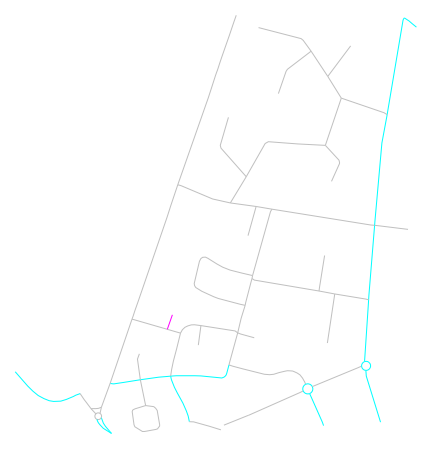

In [22]:
# get one color for each gender and plot graph
colors = ["silver", "cyan", "fuchsia"]
gender_colors = LinearSegmentedColormap.from_list("mycmap", colors)
ec = ox.plot.get_edge_colors_by_attr(G, 'gender', cmap=gender_colors)
fig, ax = ox.plot_graph(G, edge_color=ec, bgcolor='white', node_size=0)

### Final: apply to the city of Paris

In [18]:
# get road graph for the city of Paris
G = ox.graph_from_place('Paris', network_type='drive')
G = ox.get_undirected(G)

In [19]:
# preprocess and gender-classify road names
tqdm.pandas()
roads = ox.graph_to_gdfs(G, nodes=False)[['name']]
roads['name_preprocessed'] = roads['name'].apply(lambda x: unidecode(str.lower(str(x))))
roads['name_preprocessed'] = roads['name_preprocessed'].apply(lambda x: re.split(" |\-|\'", x))
roads['gender'] = roads['name_preprocessed'].progress_apply(lambda x: classify_gender(x))

/Users/Thomas/opt/miniconda3/envs/ox/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 15729/15729 [17:09<00:00, 15.27it/s] 


In [20]:
# display a sample of street genders to check
test = roads.sample(50)
test

,name,name_preprocessed,gender
9629,Rue Henri Turot,"[rue, henri, turot]",1
10745,"[Quai André Citroën, Rue Cauchy]","[[, quai, andre, citroen, ,, , rue, cauchy, ]]",1
1283,Avenue de Suffren,"[avenue, de, suffren]",1
15045,Rue de Tolbiac,"[rue, de, tolbiac]",0
9392,Rue du Docteur Finlay,"[rue, du, docteur, finlay]",1
10972,Rue de la Convention,"[rue, de, la, convention]",0
8411,Avenue Jean Aicard,"[avenue, jean, aicard]",1
7685,Boulevard Raspail,"[boulevard, raspail]",1
8719,Rue Turgot,"[rue, turgot]",1
10907,Rue Sorbier,"[rue, sorbier]",1


In [21]:
# add gender attribute to the road graph
edges = ox.graph_to_gdfs(G, nodes=False)
edges['gender'] = roads['gender']
for index, row in edges.iterrows():
    G.edges[row['u'], row['v'], row['key']]['gender'] = row['gender']

In [27]:
# choose colors
colors = ["silver", "cyan", "fuchsia"]
gender_colors = LinearSegmentedColormap.from_list("mycmap", colors)
ec = ox.plot.get_edge_colors_by_attr(G, 'gender', cmap=gender_colors)

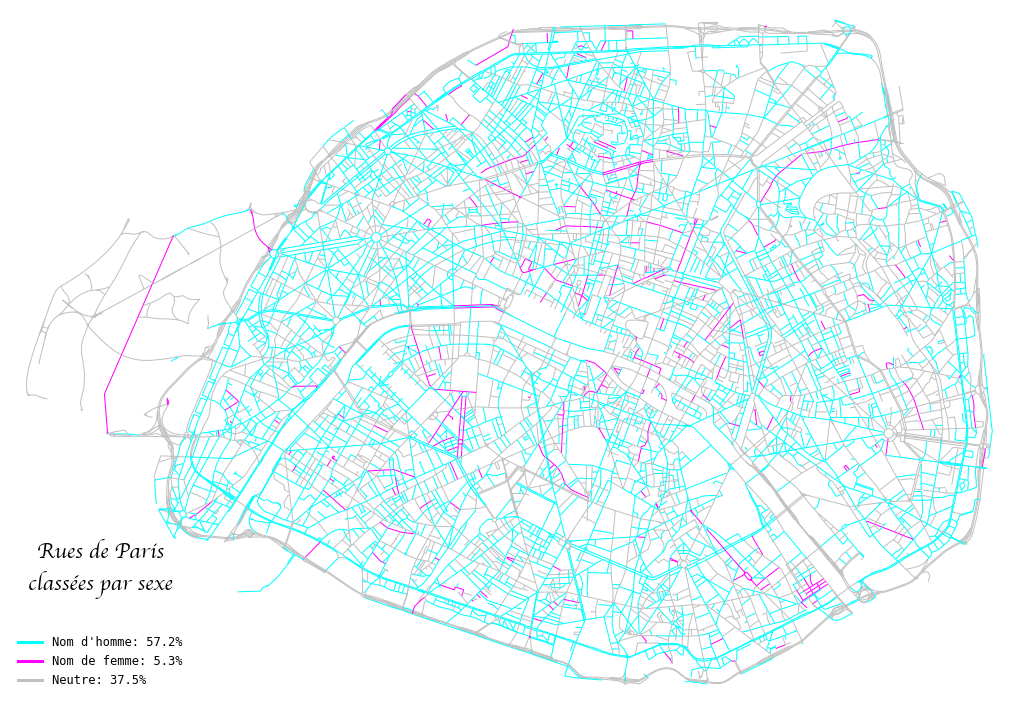

In [28]:
# plot graph
fig, ax = ox.plot_graph(G, edge_color=ec, bgcolor='white', node_size=0, figsize=(18, 18), show=False)

# plot legend
edges['name'] = edges['name'].apply(lambda x: '' if type(x)!=str else x)
edges = edges.drop_duplicates('name')
frequencies = round(edges['gender'].value_counts(normalize=True) * 100, 1)
plt.rcParams["font.family"] = "monospace"
custom_lines = [Line2D([0], [0], color='cyan', lw=3),
                Line2D([0], [0], color='fuchsia', lw=3),
                Line2D([0], [0], color='silver', lw=3)]
l = ax.legend(custom_lines, 
          [f"Nom d'homme: {frequencies[1]}%", f"Nom de femme: {frequencies[2]}%", f"Neutre: {frequencies[0]}%"],
          title="Rues de Paris\nclassées par sexe\n",
          loc='lower left', frameon=False, fontsize='large')
plt.setp(l.get_title(), multialignment='center', family='cursive', weight='black', size=22)
plt.show()

* Plot an interactive map

To plot an interactive map, we need to slightly modify the `plot_graph_folium` function so that it can plot a graph with different colors. We also need to add the color of each edge as a graph attribute.

In [29]:
# add color attribute to the road graph
edges = ox.graph_to_gdfs(G, nodes=False)
for index, row in edges.iterrows():
    if row['gender'] == 1:
        c = colors[1]
    elif row['gender'] == 2:
        c = colors[2]
    else:
        c = colors[0]
    G.edges[row['u'], row['v'], row['key']]['edge_color'] = c

In [30]:
def plot_graph_folium(
    G,
    graph_map=None,
    popup_attribute=None,
    tiles="cartodbpositron",
    zoom=1,
    fit_bounds=True,
    #edge_color="#333333",
    edge_width=5,
    edge_opacity=1,
    **kwargs,
):
    """
    Plot a graph on an interactive folium web map.
    Note that anything larger than a small city can take a long time to plot
    and create a large web map file that is very slow to load as JavaScript.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    graph_map : folium.folium.Map or folium.FeatureGroup
        if not None, plot the graph on this preexisting folium map object
    popup_attribute : string
        edge attribute to display in a pop-up when an edge is clicked
    tiles : string
        name of a folium tileset
    zoom : int
        initial zoom level for the map
    fit_bounds : bool
        if True, fit the map to the boundaries of the route's edges
    edge_color : string
        color of the edge lines
    edge_width : numeric
        width of the edge lines
    edge_opacity : numeric
        opacity of the edge lines
    kwargs : dict
        Extra keyword arguments passed through to folium
    Returns
    -------
    graph_map : folium.folium.Map
    """
    # check if we were able to import folium successfully
    if not folium:
        raise ImportError("The folium package must be installed to use this optional feature.")

    # create gdf of the graph edges
    gdf_edges = utils_graph.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)

    # get graph centroid
    x, y = gdf_edges.unary_union.centroid.xy
    graph_centroid = (y[0], x[0])

    # create the folium web map if one wasn't passed-in
    if graph_map is None:
        graph_map = folium.Map(location=graph_centroid, zoom_start=zoom, tiles=tiles)

    # add each graph edge to the map
    for _, row in gdf_edges.iterrows():
        pl = ox.folium._make_folium_polyline(
            edge=row,
            edge_color=row['edge_color'],
            edge_width=edge_width,
            edge_opacity=edge_opacity,
            popup_attribute=popup_attribute,
            **kwargs,
        )
        pl.add_to(graph_map)

    # if fit_bounds is True, fit the map to the bounds of the route by passing
    # list of lat-lng points as [southwest, northeast]
    if fit_bounds and isinstance(graph_map, folium.Map):
        tb = gdf_edges.total_bounds
        bounds = [[tb[1], tb[0]], [tb[3], tb[2]]]
        graph_map.fit_bounds(bounds)

    return graph_map

In [32]:
# plot the street network with folium
m = plot_graph_folium(G, popup_attribute='name', edge_width=2, tiles='cartodbpositron')

In [ ]:
# save as html file
m.save('paris.html')

In [161]:
# make popups appear on mouse hovering by modifying the saved html file

import fileinput

with open("/Users/Thomas/paris.html", 'r') as inf:
    txt = inf.read()
    type(txt)

#Find all the markers names given by folium
markers = re.findall(r'\bpoly_line_\w+', txt)
markers = list(set(markers))

for linenum,line in enumerate( fileinput.FileInput("paris.html",inplace=1) ):
    pattern = markers[0] + ".bindPopup"
    pattern2 = markers[0] + ".on('mouseover', function (e) {this.openPopup();});"
    pattern3 = markers[0] + ".on('mouseout', function (e) {this.closePopup();});"

    if pattern in line:
        print(line.rstrip())
        print(pattern2)
        print(pattern3)
    else:
        print(line.rstrip())

#### Notable mistakes

Misclassifications can happen for several reasons:

$\rightarrow$ When the road name exists in the list of first names and is mistakingly interpreted as a person. Example: 'Rue Blanche' where Blanche can be a first name, or 'Rue d'Odessa', 'Place d'Annecy', much rarer but apparently given to some people since 1900. In most case, once spotted we can remove the misleading first name from the list - if it's not too common and won't be needed to classify real names.\
<br>
$\rightarrow$ When the first wikipedia article appearing based on the road name isn't the one after which the road was named - for example 'Jenner' outputs 'Kylie Jenner' before 'Edward Jenner' (English physician), and 'Bosquet' outputs 'Céline Bosquet' (TV host) before 'Maréchal Bosquet'. A workaround would be to eliminate profiles whose birth date is too recent (as contemporary people often do not give their names to roads), but this would require additional wikipedia scraping.

#### Road names analysis in Paris

In [22]:
fem = list(roads[roads['gender']==2]['name'])
masc = list(roads[roads['gender']==1]['name'])
neut = list(roads[roads['gender']==0]['name'])

In [23]:
fem = [x for x in fem if type(x) == str]
fem = list(set(fem))

masc = [x for x in masc if type(x) == str]
masc = list(set(masc))

neut = [x for x in neut if type(x) == str]
neut = list(set(neut))

In [24]:
len(fem), len(masc), len(neut)

(232, 2251, 1440)

In [25]:
fem

['Rue de Florence',
 'Rue Sainte-Anne',
 'Rue Notre-Dame de Lorette',
 'Square Alice',
 'Rue de la Colombe',
 'Rue Janssen',
 'Rue de Buzenval',
 'Rue Juliette Lamber',
 'Rue Brignole',
 'Rue Delaître',
 'Rue Montalivet',
 'Rue Christine de Pisan',
 'Rue Caroline',
 'Cité Beauharnais',
 'Place de Port-au-Prince',
 'Rue Sainte-Croix de la Bretonnerie',
 'Villa de Ségur',
 'Rue Annie Girardot',
 'Rue Julia Bartet',
 'Villa Compoint',
 'Rue Danielle Casanova',
 'Allée de la Reine Marguerite',
 'Rue de Wattignies',
 'Route de la Porte Dauphine à la Porte des Sablons',
 'Rue de Laborde',
 'Rue Cavé',
 'Rue Marie-Andrée Lagroua Weill-Hallé',
 'Boulevard de la Madeleine',
 'Boulevard Poissonnière',
 'Rue Maria Deraismes',
 'Rue de Castiglione',
 "Rue de l'Harmonie",
 'Villa Flore',
 'Rue Laure Diebold',
 'Rue Christine',
 'Rue Pérignon',
 'Rue de Sévigné',
 'Rue de Sofia',
 'Rue Girodet',
 'Rue de Montpensier',
 'Boulevard des Capucines',
 'Rue de Presles',
 'Rue de Médicis',
 'Place Edwige F

### Apply to a whole department

In [19]:
# get road graph
G = ox.graph_from_place('Haute-Savoie', network_type='drive')
G = ox.get_undirected(G)

In [20]:
# check graph
#fig, ax = ox.plot_graph(G, bgcolor='white', node_size=0, figsize=(18, 18))

In [21]:
# preprocess and gender-classify road names
tqdm.pandas()
roads = ox.graph_to_gdfs(G, nodes=False)[['name']]
roads['name_preprocessed'] = roads['name'].apply(lambda x: unidecode(str.lower(str(x))))
roads['name_preprocessed'] = roads['name_preprocessed'].apply(lambda x: re.split(" |\-|\'", x))
roads['gender'] = roads['name_preprocessed'].progress_apply(lambda x: classify_gender(x))

/Users/Thomas/opt/miniconda3/envs/ox/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 59808/59808 [05:56<00:00, 167.84it/s] 


In [22]:
# display a sample of street genders to check
test = roads.sample(50)
test

,name,name_preprocessed,gender
13326,Chemin de la Croix Rouge,"[chemin, de, la, croix, rouge]",0
42948,Avenue Louis Coppel,"[avenue, louis, coppel]",1
26289,"[Route des Lacs, Route de l'Église]","[[, route, des, lacs, ,, ""route, de, l, eglise""]]",0
54668,Avenue de la Sardagne,"[avenue, de, la, sardagne]",0
36909,Avenue de Savoie,"[avenue, de, savoie]",0
58285,"[Chemin de la Grande Montagne, Route du Croix]","[[, chemin, de, la, grande, montagne, ,, , rou...",0
45444,Rue de la Gare,"[rue, de, la, gare]",0
7489,Impasse de Magie,"[impasse, de, magie]",0
50711,Avenue du Môle,"[avenue, du, mole]",0
5519,Avenue de la République,"[avenue, de, la, republique]",0


In [23]:
# add gender attribute to the road graph
edges = ox.graph_to_gdfs(G, nodes=False)
edges['gender'] = roads['gender']
for index, row in edges.iterrows():
    G.edges[row['u'], row['v'], row['key']]['gender'] = row['gender']

In [24]:
# choose colors
colors = ["silver", "cyan", "fuchsia"]
gender_colors = LinearSegmentedColormap.from_list("mycmap", colors)
ec = ox.plot.get_edge_colors_by_attr(G, 'gender', cmap=gender_colors)

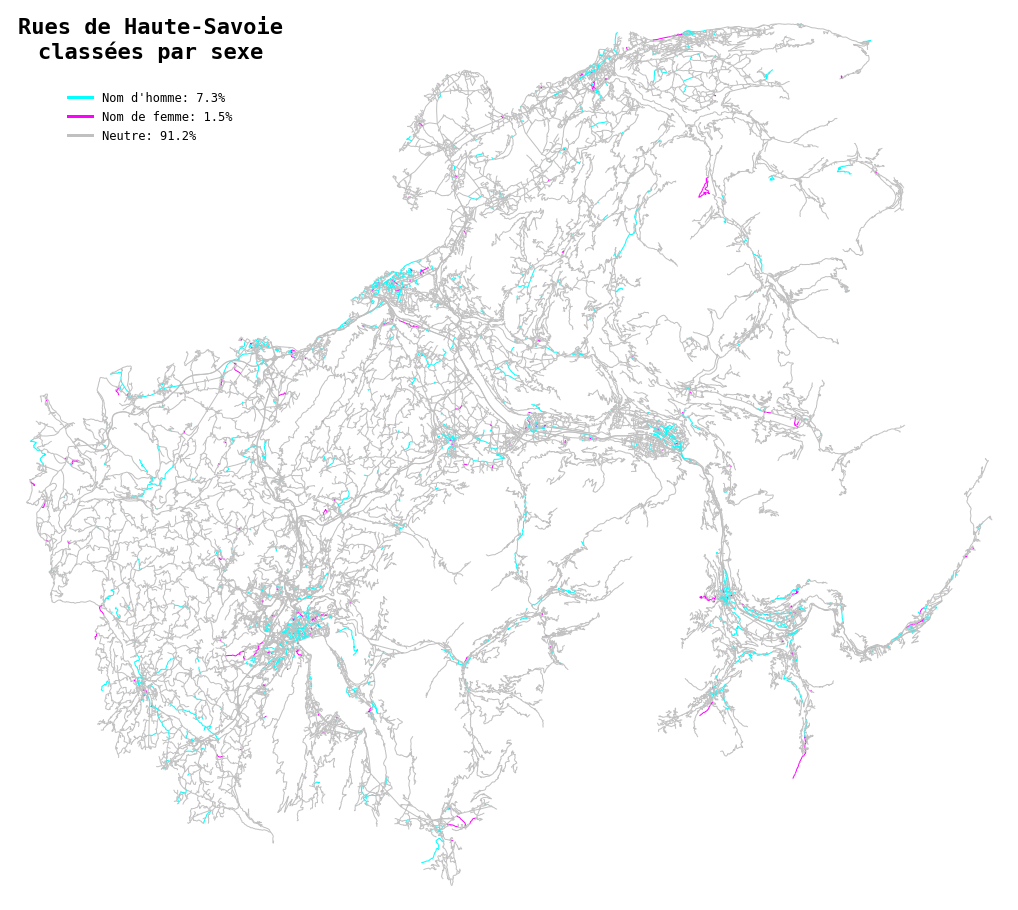

In [25]:
# plot graph
fig, ax = ox.plot_graph(G, edge_color=ec, bgcolor='white', node_size=0, figsize=(18, 18), show=False)

# plot legend
edges['name'] = edges['name'].apply(lambda x: '' if type(x)!=str else x)
edges = edges.drop_duplicates('name')
frequencies = round(edges['gender'].value_counts(normalize=True) * 100, 1)
plt.rcParams["font.family"] = "monospace"
custom_lines = [Line2D([0], [0], color='cyan', lw=3),
                Line2D([0], [0], color='fuchsia', lw=3),
                Line2D([0], [0], color='silver', lw=3)]
l = ax.legend(custom_lines, 
          [f"Nom d'homme: {frequencies[1]}%", f"Nom de femme: {frequencies[2]}%", f"Neutre: {frequencies[0]}%"],
          title="Rues de Haute-Savoie\nclassées par sexe\n",
          loc='upper left', frameon=False, fontsize='large')
plt.setp(l.get_title(), multialignment='center', family='monospace', weight='black', size=22)
plt.show()

In [59]:
# add color attribute to the road graph
edges = ox.graph_to_gdfs(G, nodes=False)
for index, row in edges.iterrows():
    if row['gender'] == 1:
        c = colors[1]
    elif row['gender'] == 2:
        c = colors[2]
    else:
        c = colors[0]
    G.edges[row['u'], row['v'], row['key']]['edge_color'] = c

In [ ]:
# plot the street network with folium
m = plot_graph_folium(G, popup_attribute='name', edge_width=1, tiles='cartodbpositron')

### Wrap up as a class

In [2]:
import pandas as pd
from unidecode import unidecode
import osmnx as ox
ox.config(use_cache=True, log_console=True)
from osmnx import utils_graph
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import wikipedia
wikipedia.set_lang('fr')
from itertools import chain
import json
import folium

class StreetGender:
    
    def __init__(self, place: str):
        
        # download and clean INSEE's list of first names
        genders = pd.read_csv('https://www.insee.fr/fr/statistiques/fichier/2540004/nat2019_csv.zip', sep=";")[['preusuel','sexe', 'nombre']]
        genders['preusuel'] = genders['preusuel'].apply(lambda x: unidecode(str.lower(str(x))))
        genders = genders.sort_values('nombre').drop_duplicates('preusuel', keep='last')
        genders = genders[genders['nombre']>=100]
        mistakes = ['france', 'alma', 'barbe', 'lilas', 'milan', 'brune', 'felicite',
                    'nancy', 'grace', 'lorraine', 'blanche', 'evy', 'loup', 'iris']
        genders = genders[~genders['preusuel'].isin(mistakes)]
        genders = genders.reset_index(drop=True).drop(columns=['nombre'])
        
        # add English first names
        genders_en = pd.read_csv('https://www.nrscotland.gov.uk/files//statistics/babies-names/19/babies-first-names-all-names-all-years.csv')[['sex','FirstForename','number']]
        genders_en = genders_en[genders_en['number']>=20]
        genders_en['preusuel'] = genders_en['FirstForename'].apply(lambda x: unidecode(str.lower(str(x))))
        genders_en = genders_en.drop_duplicates('preusuel')
        genders_en = genders_en[~genders_en['preusuel'].isin(mistakes)]
        genders_en['sexe'] = genders_en['sex'].apply(lambda x: 1 if x=='B' else 2)
        genders_en = genders_en.reset_index(drop=True).drop(columns=['FirstForename','number','sex'])

        # complement the gender table
        more_names = {
            # titles
            'Maréchal':1, 'Maréchaux':1, 'Général':1, 'Capitaine':1, 'Commandant':1, 'Adjudant':1,
            'Colonel':1, 'Amiral':1, 'Amiraux':1, 'Caporal':1, 'Sergent':1, 'Brigadier':1,
            'Soldat':1, 'Lieutenant':1, 'Major':1, 'Commandeur':1,

            'Saint':1, 'Saints':1, 'Sainte':2, 'Saintes':2, 'Révérend':1, 'Mère':2, 'Père':1,
            'Bienheureux':1, 'Bienheureuse':2, 'Bienheureuses':2, 'Chanoine':1, 'Cardinal':1,
            'Evêque':1, 'Evêques':1, 'Archevêque':1, 'Abbé':1, 'Abbesse':2, 'Vicaire':1, 'Papes':1,
            'Dieu':1, 'Dieux':1, 'Déesse':2, 'Déesses':2, 'Capucins':1, 'Capucines':2, 'Moine':1,
            'Moines':1, 'Moniales':2,

            'Duc':1, 'Ducs':1, 'Duchesse':2, 'Duchesses':2, 'Comte':1, 'Comtes':1, 'Comtesse':2, 
            'Comtesses':2, 'Vicomte':1, 'Vicomtesse':2, 'Baron':1, 'Barons':1, 'Baronne':2,
            'Baronnes':2, 'Princesse':2, 'Prince':2, 'Roi':1, 'Rois':1, 'Reine':2, 'Reines':2,
            'Marquise':2, 'Marquis':1, 'Lord':1, 'Lady':2, 'Dauphin':1, 'Dauphine':2, 'Chevalier':1, 
            'Archiduc':1, 'Infante':2, 'Empereur':1, 'Emperesse':2, 'Régent':1, 'Régente':2,
            'Chatelain':1, 'Chatelaine':2, 'Chapelaines':2,

            'Président':1, 'Présidente':2, 'Consul':1, 'Maire':1, 'Ambassadeur':1, 'Ambassadeurs':1,
            'Ambassadrice':2, 'Ambassadrices':2, 'Directeur':1, 'Directrice':2, 'Docteur':1, 'Inspecteur':1,

            'Professeur':1, 'Maître':1, 'Maîtresse':2, 'Joueur':1, 'Joueurs':1, 'Joueuse':2, 'Joueuses':2,
            'Fille':2, 'Filles':2, 'Fils':1, 'Soeur':2, 'Soeurs':2, 'Frère':1, 'Frères':1,

            'Mademoiselle':2, 'Demoiselle':2, 'Demoiselles':2, 'Dame':2, 'Dames':2, 'Messieurs':1, 'Mesdames':2,
            'Monseigneur':1, 'Seigneur':1, 'Seigneurs':1, 'Messire':1, 'Madame':2, 'Monsieur':1,

            # mistakes
            'Vinci':1, 'Gogh':1, 'Rembrandt':1, 'Gandhi':1, 'Sisley':1, 'Loo':1, 'Péguy':1, 'Turgot':1,
            'Pleyel':1, 'Jenner':1, 'Chanez':1, 'Auber':1, 'Pradier':1, 'Huysmans':1, 'Barrault':1,
            'Richer':1, 'Boutin':1, 'Fortuny':1, 'Bouchardon':1, 'Valadon':1, 'Payenne':1, 'Brey':1,
            'Godefroy':1, 'Tagore':1, 'Berthollet':1, 'Nobel':1, 'Viollet':1, 'Vavin':1, 'Rossini':1,
            'Castille':2, 'Brun':1, 'Boétie':1, 'Evariste':1, 'Godefroy':1, 'Valois':1, 'Goncourt':1,
            'Tchaikovsky':1, 'Nicolai':1, 'Paganini':1, 'Bernoulli':1, 'Alembert':1, 'Marx':1, 'Franklin':1,
            'Reynaldo':1, 'Berri':1, 'Bruyere':1, 'Lesseps':1, 'Fenelon':1, 'Mareuil':1,
            'Dupont':1, 'Malmaisons':2, 'Malmaison':2, 'Valois':1, 'Blaise':1, 'Bougainville':1, 'Louvois':1,
            'Colbert':1, 'Faustin':1, 'Chavez':1, 'Mozart':1, 'Desprez':1, 'Froidevaux':1, 'Chapon':1,
            'Gluck':1, 'Berthier':1, 'Grimaud':1, 'Chapon':1, 'Bouvier':1, 'Gauthey':1, 'Dyck':1, 'Monceau':0,
            'Royal':0, 'Favart':1, 'Rauch':1, 'Jonquoy':1, 'Gerando':1, 'Bruller':1, 'Cepre':1, 'Pinel':1,
            'Laferrière':1, 'Gaetano':1, 'Lentonnet':1, 'Mignot':1, 'Mayet':1, 'Pasquier':1, 'Taylor':1,
            'Dubois':1, 'Brunel':1, 'Hebert':1, 'Lagrange':1, 'Junot':1, 'Dieulafoy':1, 'Houdart':1,
            'Franz':1, 'Mouraud':1, 'Andrieux':1, 'Valette':1, 'Joubert':1, 'Ferrus':1, 'Portefoin':1,
            'Hoche':1, 'Fourneyron':1, 'Lemercier':1, 'Polonceau':1, 'Sibour':1, 'Petrarque':1, 'Bourgoin':1,
            'Thouin':1, 'Benard':1, 'Guénégaud':1, 'Tracy':1, 'Calmels':1, 'Geoffroi':1, 'Villiot':1,
            'Greffulhe':1, 'Tarbé':1, 'Daunay':1, 'Larribe':1, 'Riboutté':1, 'Johannes':1, 'Iannis':1,
            'Guglielmo':1, 'Guillermo':1}

        more_names = pd.DataFrame.from_dict(more_names, orient='index')
        more_names = more_names.reset_index()
        more_names.columns = ['preusuel','sexe']
        genders = pd.concat([genders, more_names, genders_en], axis=0)
        genders = genders.drop_duplicates('preusuel')
        genders =  genders.reset_index(drop=True)
        genders['preusuel'] = genders['preusuel'].apply(lambda x: unidecode(str.lower(str(x))))
        
        self.gender_table = genders
        self.place = place
        self._road_graph = None
        self._road_table = None
        self._road_genders = None
        
       
    @property
    def road_graph(self):
        try:
            return self._road_graph
        except AttributeError:
            G = ox.graph_from_place(self.place, network_type='drive')
            G = ox.get_undirected(G)
            self._road_graph = G
        return self._road_graph

    
    @property
    def road_table(self):
        try:
            return self._road_table
        except AttributeError:
            try:
                G = self._road_graph
            except AttributeError:
                G = self.road_graph()
            roads = ox.graph_to_gdfs(G, nodes=False)[['name']]
            self._road_table = roads
            return self._road_table

       
    def classify_gender(self, name: list):
        # set gender to neutral
        g = 0

        # iterate through elements of the road name to try classifying
        for el in name:
            try:
                g = int(self.gender_table[self.gender_table['preusuel']==el]['sexe'])
                break
            except:
                continue

        # for the names that remained neutral, search wikipedia
        if g == 0 and len(name)==2:
            results = wikipedia.search(name[1])[:4]
            results = [re.split(" |\-|\'", k) for k in results]
            results = list(chain.from_iterable(results))
            for k in results:
                k = unidecode(str.lower(str(k)))
                try:
                    g = int(self.gender_table[self.gender_table['preusuel']==k]['sexe'])
                    break
                except:
                    continue  

        elif g == 0 and len(name)==3 and name[1] in ['le','la', 'de']:
            results = wikipedia.search(name[2])[:3]
            results = [re.split(" |\-|\'", k) for k in results]
            results = list(chain.from_iterable(results))
            for k in results:
                k = unidecode(str.lower(str(k)))
                try:
                    g = int(self.gender_table[self.gender_table['preusuel']==k]['sexe'])
                    break
                except:
                    continue  
        return g

    
    def road_genders(self, gender=None):
        tqdm.pandas()
        try:
            roads = self._road_genders
            if gender == None:
                return self._road_genders
            else:
                if gender == 'M':
                    return self.masculine
                elif gender == 'F':
                    return self.feminine
                elif gender == 'N':
                    return self.neutral
                else:
                    raise ValueError("Please pass 'M', 'F' or 'N' as gender.")
                
        except AttributeError:
            try:
                roads = self._road_table
            except AttributeError:
                roads = self.road_table()
            roads['name_preprocessed'] = roads['name'].apply(lambda x: unidecode(str.lower(str(x))))
            roads['name_preprocessed'] = roads['name_preprocessed'].apply(lambda x: re.split(" |\-|\'", x))
            roads['gender'] = roads['name_preprocessed'].progress_apply(lambda x: classify_gender(x))
            self._road_genders = roads
            
            masc = list(roads[roads['gender']==1]['name'])
            self.masculine = [x for x in masc if type(x) == str]
            fem = list(roads[roads['gender']==2]['name'])
            self.feminine = [x for x in fem if type(x) == str]
            neut = list(roads[roads['gender']==0]['name'])
            self.neutral = [x for x in neut if type(x) == str]
            
            if gender == None:
                return self._road_genders
            else:
                if gender == 'M':
                    return self.masculine
                elif gender == 'F':
                    return self.feminine
                elif gender == 'N':
                    return self.neutral
                else:
                    raise ValueError("Please pass 'M', 'F' or 'N' as gender.")
    
    
    def plot_graph(self, colors=["silver", "cyan", "fuchsia"], legend_loc='lower left'):
        try:
            roads = self.road_genders
        except AttributeError:
            roads = self.get_genders()

        # add gender attribute to the road graph
        G = self.road_graph
        edges = ox.graph_to_gdfs(G, nodes=False)
        edges['gender'] = roads['gender']
        for index, row in edges.iterrows():
            G.edges[row['u'], row['v'], row['key']]['gender'] = row['gender']

        # choose colors
        gender_colors = LinearSegmentedColormap.from_list("mycmap", colors)
        ec = ox.plot.get_edge_colors_by_attr(G, 'gender', cmap=gender_colors)

        # plot graph
        fig, ax = ox.plot_graph(G, edge_color=ec, bgcolor='white', node_size=0, figsize=(18, 18), show=False)

        # plot legend
        edges['name'] = edges['name'].apply(lambda x: '' if type(x)!=str else x)
        edges = edges.drop_duplicates('name')
        frequencies = round(edges['gender'].value_counts(normalize=True) * 100, 1)
        plt.rcParams["font.family"] = "monospace"
        custom_lines = [Line2D([0], [0], color='cyan', lw=3),
                        Line2D([0], [0], color='fuchsia', lw=3),
                        Line2D([0], [0], color='silver', lw=3)]
        l = ax.legend(custom_lines, 
                  [f"Nom d'homme: {frequencies[1]}%", f"Nom de femme: {frequencies[2]}%", f"Neutre: {frequencies[0]}%"],
                  title=f"Rues de {self.place}\nclassées par sexe\n",
                  loc=legend_loc, frameon=False, fontsize='large')
        plt.setp(l.get_title(), multialignment='center', family='monospace', weight='black', size=22)
        plt.show()

    
    def plot_folium(self, colors=["silver", "cyan", "fuchsia"], save=False):
        try:
            roads = self.road_genders
        except AttributeError:
            roads = self.get_genders()

        # add gender attribute to the road graph
        G = self.road_graph
        edges = ox.graph_to_gdfs(G, nodes=False)
        edges['gender'] = roads['gender']
        for index, row in edges.iterrows():
            G.edges[row['u'], row['v'], row['key']]['gender'] = row['gender']

        # add color attribute to the road graph
        edges = ox.graph_to_gdfs(G, nodes=False)
        for index, row in edges.iterrows():
            if row['gender'] == 1:
                c = colors[1]
            elif row['gender'] == 2:
                c = colors[2]
            else:
                c = colors[0]
            G.edges[row['u'], row['v'], row['key']]['edge_color'] = c

        # plot the street network with folium
        m = _plot_graph_folium(G, popup_attribute='name', edge_width=2, tiles='cartodbpositron')
        if save:
            m.save('paris.html')

        return m

    
    @staticmethod
    def _plot_graph_folium(G, graph_map=None, popup_attribute=None,
                           tiles="cartodbpositron", zoom=1, fit_bounds=True,
                           edge_width=5, edge_opacity=1, **kwargs):
        """
        Plot a graph on an interactive folium web map.
        Note that anything larger than a small city can take a long time to plot
        and create a large web map file that is very slow to load as JavaScript.
        Parameters
        ----------
        G : networkx.MultiDiGraph
            input graph
        graph_map : folium.folium.Map or folium.FeatureGroup
            if not None, plot the graph on this preexisting folium map object
        popup_attribute : string
            edge attribute to display in a pop-up when an edge is clicked
        tiles : string
            name of a folium tileset
        zoom : int
            initial zoom level for the map
        fit_bounds : bool
            if True, fit the map to the boundaries of the route's edges
        edge_color : string
            color of the edge lines
        edge_width : numeric
            width of the edge lines
        edge_opacity : numeric
            opacity of the edge lines
        kwargs : dict
            Extra keyword arguments passed through to folium
        Returns
        -------
        graph_map : folium.folium.Map
        """
        # check if we were able to import folium successfully
        if not folium:
            raise ImportError("The folium package must be installed to use this optional feature.")

        # create gdf of the graph edges
        gdf_edges = utils_graph.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)

        # get graph centroid
        x, y = gdf_edges.unary_union.centroid.xy
        graph_centroid = (y[0], x[0])

        # create the folium web map if one wasn't passed-in
        if graph_map is None:
            graph_map = folium.Map(location=graph_centroid, zoom_start=zoom, tiles=tiles)

        # add each graph edge to the map
        for _, row in gdf_edges.iterrows():
            pl = ox.folium._make_folium_polyline(
                edge=row,
                edge_color=row['edge_color'],
                edge_width=edge_width,
                edge_opacity=edge_opacity,
                popup_attribute=popup_attribute,
                **kwargs,
            )
            pl.add_to(graph_map)

        # if fit_bounds is True, fit the map to the bounds of the route by passing
        # list of lat-lng points as [southwest, northeast]
        if fit_bounds and isinstance(graph_map, folium.Map):
            tb = gdf_edges.total_bounds
            bounds = [[tb[1], tb[0]], [tb[3], tb[2]]]
            graph_map.fit_bounds(bounds)

        return graph_map

In [3]:
combloux = StreetGender('Combloux')

In [5]:
G = combloux.road_graph

In [7]:
type(G)

NoneType